# Data Wrangling of one file tracking data

The dataset contains 5min of tracking information for each player in a club, recording their precise x and y coordinates.

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
import matplotlib.cm as cm
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import tracking data from one recording of 5 minutes

In [133]:
data = pd.read_csv("tracking_data.txt", sep=",", header=None)
data.columns = ["frame_number", "track_id", "role", "xbox", "ybox", "w", "h", "xworld", "yworld", "IoU"]
data.head()

,frame_number,track_id,role,xbox,ybox,w,h,xworld,yworld,IoU
0,0,61,0,1596.2,265.0,62.1,97.6,47.6,48.1,0.00
1,0,62,1,1646.2,146.1,31.3,58.7,47.8,31.9,0.00
2,0,63,0,1590.5,165.0,28.6,61.5,46.3,35.2,0.00
3,0,64,3,855.9,292.0,34.5,51.7,19.3,33.5,0.00
4,0,65,1,1770.2,95.4,19.4,38.7,52.4,13.6,0.05


`role` feature:
* 0/1 - players
* 2 - ref
* 3/4 - goalies
* -1 - unused detections (non-players and non-refs)
  

`xworld` and `yworld` are in meters measured from the back left corner flag (from the point of view of the camera).

In [134]:
data.shape

(28565, 10)

In [135]:
data["track_id"].nunique()

30

We have 30 unique tracking IDs, representing only the outfield players and referees.

As a result, there may be instances where non-player or non-referee objects are detected, or cases where an object is reassigned or re-identified. This can happen in highly occluded situations (in football these are corners or free kicks, with a large number of players on a small area of the pitch)

In [136]:
data["role"].value_counts()

role
 0    12469
 1    12455
 2     1250
 4     1250
 3     1134
-1        7
Name: count, dtype: int64

In [137]:
data = data.drop( ["xbox", "ybox", "w", "h"], axis=1)

In [138]:
data[(data["frame_number"] == 0) & (data["role"] == 0)]

,frame_number,track_id,role,xworld,yworld,IoU
0,0,61,0,47.6,48.1,0.00
2,0,63,0,46.3,35.2,0.00
8,0,69,0,55.6,36.8,0.01
13,0,74,0,80.3,38.9,0.00
14,0,75,0,62.4,36.4,0.00
15,0,76,0,78.6,53.1,0.00
19,0,80,0,75.7,31.1,0.09
20,0,81,0,71.5,28.7,0.00
22,0,83,0,53.7,18.7,0.00
24,0,85,0,56.8,25.8,0.01


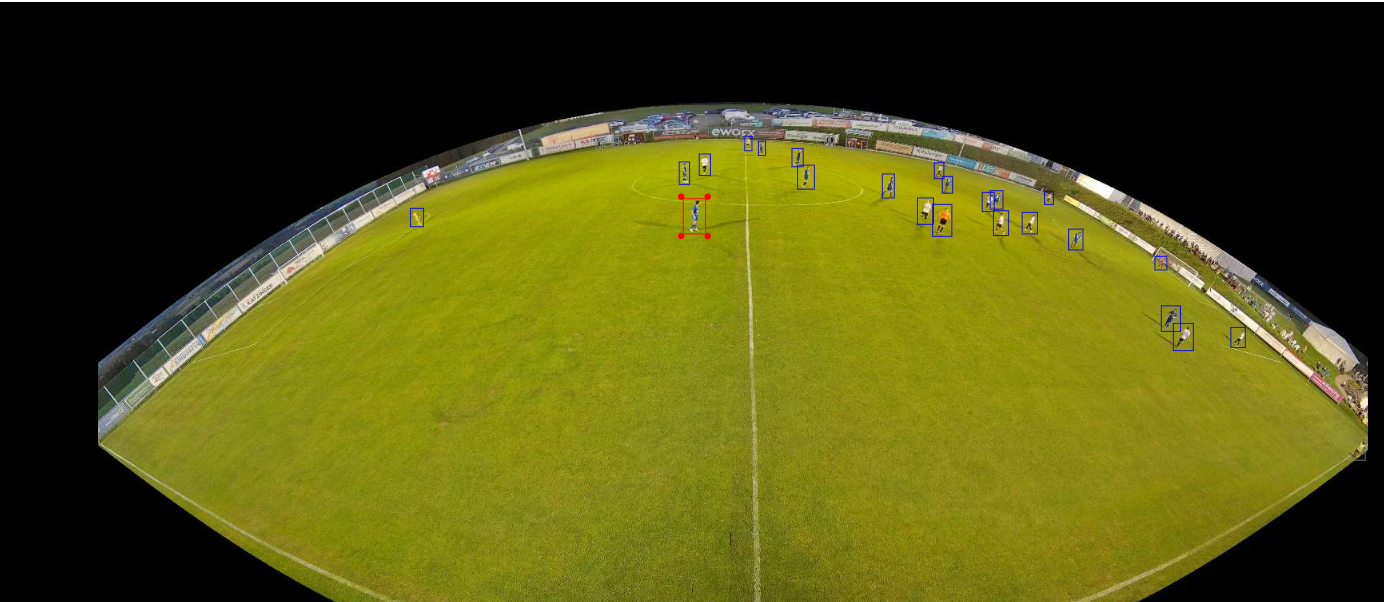

# EDA

In [139]:
data_team0 = data[data["role"] == 0]
data_team0["track_id"].nunique()   


10

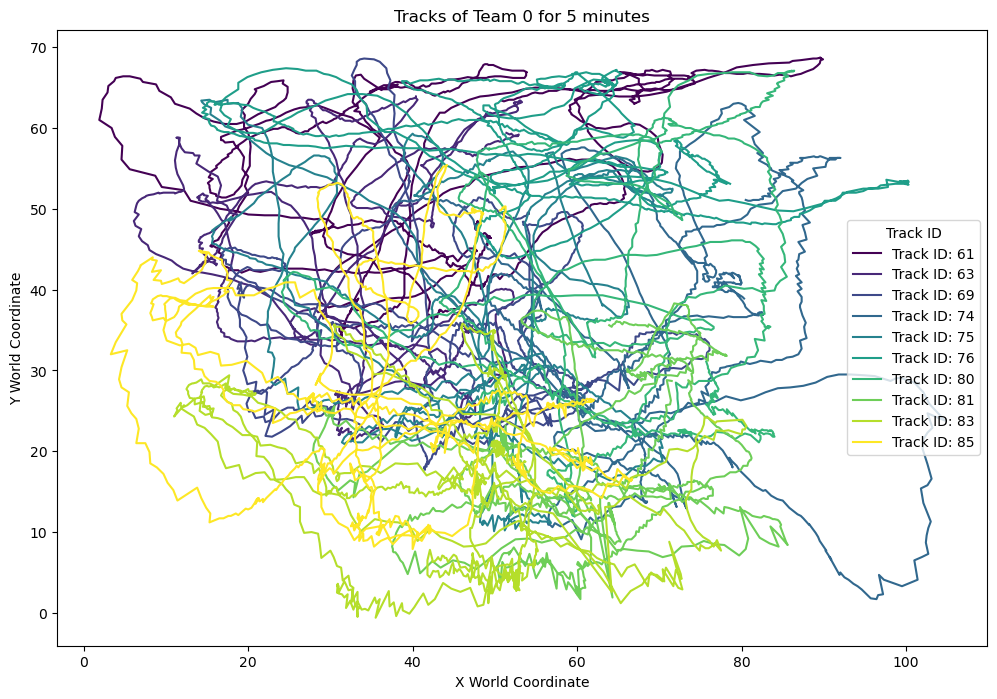

In [140]:
# Get unique track IDs
unique_tracks = data_team0['track_id'].unique()

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_tracks)))
for idx, track_id in enumerate(unique_tracks):
    track_data = data_team0[data_team0['track_id'] == track_id]
    plt.plot(track_data['xworld'], track_data['yworld'], color=colors[idx], linestyle='-', markersize=1, label=f'Track ID: {track_id}')

plt.title('Tracks of Team 0 for 5 minutes')
plt.xlabel('X World Coordinate')
plt.ylabel('Y World Coordinate')
plt.legend(title='Track ID')
plt.show()

In [141]:
data[(data["frame_number"] >= 0) & (data["track_id"] == 61)]

,frame_number,track_id,role,xworld,yworld,IoU
0,0,61,0,47.6,48.1,0.0
30,6,61,0,47.8,48.1,0.0
53,12,61,0,47.9,48.5,0.0
76,18,61,0,47.9,48.5,0.0
99,24,61,0,47.9,48.5,0.0
...,...,...,...,...,...,...
28466,7470,61,0,52.3,63.5,0.0
28488,7476,61,0,51.9,63.5,0.0
28510,7482,61,0,51.7,63.5,0.0
28532,7488,61,0,51.1,63.3,0.0


In [142]:
player_61 = data[(data["track_id"] == 61) & (data["role"] == 0)]
player_61_xy = pd.DataFrame({'x': player_61["xworld"], 'y': player_61["yworld"]})

In [143]:
def create_pitch(df):
    # mirror the y-axis
    df['y'] = 68 - df['y']
 
    fig, ax = plt.subplots(figsize=(12, 8))

    
    ax.set_facecolor('green')
    plt.plot([0, 0, 105, 105, 0], [0, 68, 68, 0, 0], color="white")
    plt.plot([16.5, 16.5, 0, 0, 16.5], [21.16, 46.84, 46.84, 21.16, 21.16], color="white")
    plt.plot([105, 105 - 16.5, 105 - 16.5, 105, 105], [21.16, 21.16, 46.84, 46.84, 21.16], color="white")
    plt.plot([0, 6, 6, 0], [30.9, 30.9, 37.1, 37.1], color="white")
    plt.plot([105, 105 - 6, 105 - 6, 105], [30.9, 30.9, 37.1, 37.1], color="white")

    center_circle = plt.Circle((52.5, 34), 9.15, color="white", fill=False)
    ax.add_patch(center_circle)

    plt.plot([52.5, 52.5], [0, 68], color="white")
    plt.plot(11, 34, 'wo')  
    plt.plot(94, 34, 'wo')  
    plt.plot(52.5, 34, 'wo')  
    plt.plot([0, 0], [30.9, 37.1], color="white", linewidth=8)  
    plt.plot([105, 105], [30.9, 37.1], color="white", linewidth=8)  

    ax.set_xlim(-5, 110)
    ax.set_ylim(-5, 73)
    ax.set_aspect('equal')

   
    plt.xticks([])
    plt.yticks([])

    
    plt.title('Player tracking - 5min', fontsize=20)
    

    sns.kdeplot(x=df['x'], y=df['y'], ax=ax, shade=True, cmap="coolwarm", n_levels=30, alpha=0.7, label='Movement Density')
    plt.plot(df['x'], df['y'], color='blue', linestyle='-', marker='o', markersize=3, label='Player Runline')
    plt.scatter(df['x'].iloc[0], df['y'].iloc[0], color='green', s=100, label='Start Point', edgecolor='black')
    plt.scatter(df['x'].iloc[-1], df['y'].iloc[-1], color='red', s=100, label='End Point', edgecolor='black')

    plt.legend()
    plt.grid(False)
    plt.show()

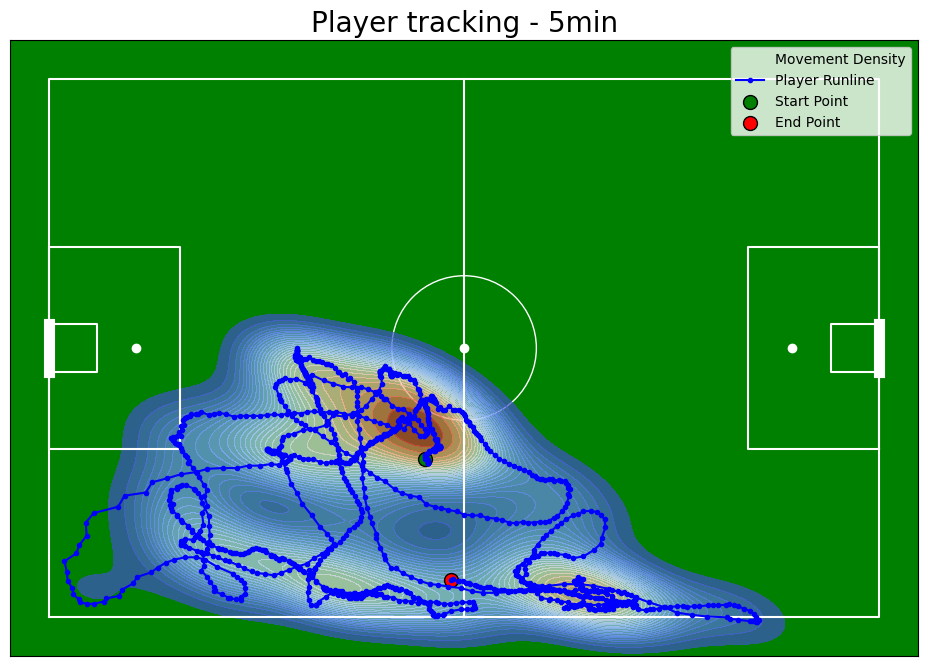

In [144]:
create_pitch(player_61_xy)

Add convex hull

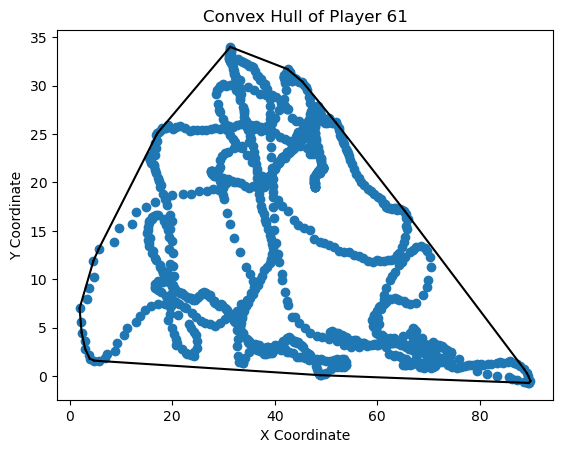

In [145]:
points = player_61_xy[['x', 'y']].values
hull = ConvexHull(points)
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Convex Hull of Player 61')
plt.show()

In [146]:
players_role_0 = data[data["role"] == 0]

C:\Users\sbart\AppData\Local\Temp\ipykernel_16292\804973175.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("tab20", len(players_role_0['track_id'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


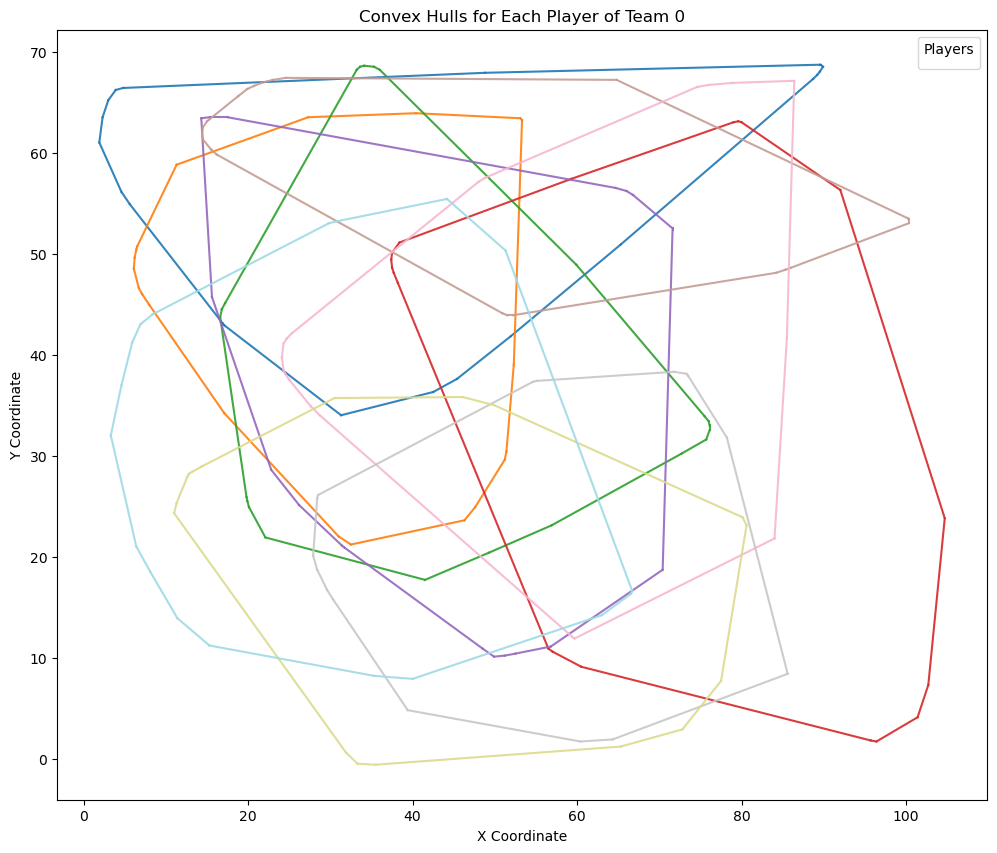

In [154]:
plt.figure(figsize=(12, 10))

# Define a color map to assign different colors to each player
color_map = cm.get_cmap("tab20", len(players_role_0['track_id'].unique()))


for i, player_id in enumerate(players_role_0['track_id'].unique()):
    player_data = players_role_0[players_role_0['track_id'] == player_id]
    points = player_data[['xworld', 'yworld']].values  
    
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        
  
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], '-', color=color_map(i), alpha=0.9)
    
plt.title('Convex Hulls for Each Player of Team 0')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(loc="best", title="Players")
plt.show()


# All files
The entire dataset consists of 512897 datapoints.

In [ ]:
file_paths = glob.glob('xy data/*.txt')
tracking_data = pd.concat((pd.read_csv(file, sep=",", header=None) for file in file_paths), ignore_index=True)
tracking_data.columns = ["frame_number", "track_id", "role", "xbox", "ybox", "w", "h", "xworld", "yworld", "IoU"]
tracking_data.info

<bound method DataFrame.info of         frame_number  track_id  role    xbox   ybox     w      h  xworld  \
0                  0       105     0   941.1  505.4  80.4  129.6    38.4   
1                  0        92     2   969.1  304.0  49.3   73.4    30.5   
2                  0        93     1   815.5  401.7  60.6   80.4    29.3   
3                  0        94     1  1536.3  206.7  37.9   70.7    45.5   
4                  0        95     1   866.6  288.7  33.0   47.8    19.2   
...              ...       ...   ...     ...    ...   ...    ...     ...   
512892          7494       508     0   893.7  451.8  30.9   52.0    24.0   
512893          7494       507     0  1285.6  360.8  25.4   38.6    32.9   
512894          7494       516     1  1114.7  382.6  21.3   33.8    24.5   
512895          7494       512     0  1039.8  401.4  26.8   40.0    23.8   
512896          7494       528     1  1400.6  327.9  15.5   24.4    32.8   

        yworld   IoU  
0         57.1  0.00  
1        

In [149]:
tracking_data.shape

(512897, 10)

In [150]:
tracking_data["track_id"].nunique()

464

In [151]:
tracking_data["role"].value_counts()

role
 1      221990
 0      221469
 2       27990
 4       19862
 3       19752
 155       507
 166       506
 400       361
 396       345
-1         115
Name: count, dtype: int64

At fis2 and stv2 we have unclear roles

In [152]:
tracking_data[tracking_data["role"] == 400]

,frame_number,track_id,role,xbox,ybox,w,h,xworld,yworld,IoU
391508,400,400,400,400.0,400.0,400.0,400.0,400.0,400.0,400.0
391528,400,400,400,400.0,400.0,400.0,400.0,400.0,400.0,400.0
391548,400,400,400,400.0,400.0,400.0,400.0,400.0,400.0,400.0
391570,400,400,400,400.0,400.0,400.0,400.0,400.0,400.0,400.0
391591,400,400,400,400.0,400.0,400.0,400.0,400.0,400.0,400.0
...,...,...,...,...,...,...,...,...,...,...
399607,400,400,400,400.0,400.0,400.0,400.0,400.0,400.0,400.0
399630,400,400,400,400.0,400.0,400.0,400.0,400.0,400.0,400.0
399652,400,400,400,400.0,400.0,400.0,400.0,400.0,400.0,400.0
399674,400,400,400,400.0,400.0,400.0,400.0,400.0,400.0,400.0
